# Map projections

A **coordinate reference systems (CRS)** is a crucial piece of metadata for any
geospatial data set. Without a CRS, the geometries would simply be a collection
of coordinates in an arbitrary space. Only the CRS allows GIS software,
including the Python packages we use in this course, to relate these
coordinates to a place on Earth (or other approximately spherical objects or
planets).

Often conflated with coordinate reference systems, and definitely closely
related, are **map projections**. Map projections, also called *projected
coordinate systems*, are mathematical models that allow us to transfer
coordinates on the surface of our **three-dimensional Earth** into coordinates
in a planar surface, such as a **flat, two-dimensional map**. In contrast to
projected coordinate systems, *geographic coordinate systems* simply directly
use latitude and longitude, i.e. the degrees along the horizontal and vertical
great circles of a sphere approximating the Earth, as the x and y coordinates
in a planar map. Finally, there are both projected and geographic coordinate
systems that make use of more complex ellipsoids than a simple sphere to better
approximate the ‘potato-shaped’ reality of our planet. The full CRS information
needed to accurately relate geospatial information to a place on Earth includes
both (projected/geographic) coordinate system and ellipsoid.

The CRS in different spatial datasets differ fairly often, as different
coordinate systems are optimised for certain regions and purposes. No
coordinate system can be perfectly accurate around the globe, and the
transformation from three- to two-dimensional coordinates can not be accurate
in angles, distances, and areas simultaneously.

Consequently, it is a common GIS task to **transform** (or reproject) a data
set from one references system into another, for instance, to make two layers
interoperatable. Comparing two data sets that have different CRS would
inevitably produce wrong results; for example, finding points contained within
a polygon cannot work, if the the points have geographic coordinates (in
degrees), and the polygon is in the national Finnish reference system (in
meters).

Choosing an appropriate projection for your map is not always straightforward.
It depends on what you actually want to represent in your map, and what your
data’s spatial scale, resolution and extent are. In fact, there is not a single
‘perfect projection’; each has strengths and weaknesses, and you should choose
a projection that fits best for each map. In fact, the projection you choose
might even tell something about you:


![What’s that? You think I don’t like the Peters map because I’m uncomfortable with having my cultural assumptions challenged? Are you sure you’re not ... *puts on sunglasses* ... projecting?](https://imgs.xkcd.com/comics/map_projections.png)

The XKCD web comic had it figured out long ago: ‘What your favourite map projection tells about you’.  
*Source: [xkcd.com](https://xkcd.com/977)*

---

> **Note**  
> For those of you who prefer a more analytical approach to choosing map projections: you can get a good overview from [georeference.org](http://www.georeference.org/doc/guide_to_selecting_map_projections.htm), and this blog post discussing [the strengths and weaknesses of a few commonly used projections](http://usersguidetotheuniverse.com/index.php/2011/03/03/whats-the-best-map-projection/).  
> The web page *Radical Cartography* has an excellent [overview of which projections fit which extent of the world for which topic](https://radicalcartography.net/projectionref.html).

---

## Handling coordinate reference systems in Geopandas

Once you have figured out which map projection to use, handling coordinate reference systems, fortunately, is fairly easy in Geopandas. The library [pyproj](https://pyproj4.github.io/pyproj/) provides additional information about a CRS and can assist with more tricky tasks, such as guessing the unknown CRS of a data set.

In this section, we will learn **how to retrieve the coordinate reference system information of a data set, and how to re-project the data into another CRS**.

---

> **Caution: Careful with Shapefiles**  
> You might have noticed that geospatial data sets in *ESRI Shapefile* format consist of multiple files with different file extensions. The `.prj` file contains information about the coordinate reference system. Be careful not to lose it!



### Displaying the CRS of a data set

We will start by loading a data set of EU countries that has been downloaded
from the [*Geographic Information System of the Commission*
(GISCO)](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/countries),
a unit within Eurostat that manages geospatial data for the European
Commission.

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [2]:
import geopandas

eu_countries = geopandas.read_file(
    DATA_DIRECTORY / "eu_countries" / "eu_countries_2022.gpkg"
)

Let’s check the data set’s CRS:

In [3]:
eu_countries.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

What we see here is, in fact, a `pyproj.CRS` object. 

The EPSG code (*European Petroleum Survey Group*) is global standard for
identifying coordinate reference systems. The number refers to an entry in the
[EPSG Geodetic Parameter Dataset](http://www.epsg.org/), a collection of
coordinate reference systems coordinate transformations ranging from global to
national, regional, and local scope.

Our `GeoDataFrame`’s EPSG code is `4326`. This is number to remember, as you
will come across it a lot in the geospatial world: It refers to a geographic
coordinate system using the WGS-84 reference ellipsoid. This is the most
commonly used coordinate reference system in the world. It’s what we refer to
when we speak of longitude and latitude.

You can find information about reference systems and lists of commonly known
CRS from many online resources, for example:
- [spatialreference.org](http://spatialreference.org/)
- [proj4.org](https://proj4.org/operations/projections/)
- [mapref.org](http://mapref.org/CollectionofCRSinEurope.html)


> **Tip**  
> If you know what range the coordinate values should be in, it doesn’t hurt to take a quick look at the data itself. In the case of `EPSG:4326`, coordinates should be between -180 and 180° longitude and -90 and 90° latitude.


In [4]:
eu_countries.geometry.head()

0    MULTIPOLYGON (((13.684 46.4375, 13.511 46.3484...
1    MULTIPOLYGON (((6.3156 50.497, 6.405 50.3233, ...
2    MULTIPOLYGON (((28.498 43.4341, 28.0602 43.316...
3    MULTIPOLYGON (((16.9498 48.5358, 16.8511 48.43...
4    MULTIPOLYGON (((32.9417 34.6418, 32.559 34.687...
Name: geometry, dtype: geometry

Indeed, the coordinate values of our data set seem to be in an appropriate value range.


---


### Reprojecting a `GeoDataFrame` 

A geographic coordinate system, `EPSG:4326`, is not particularly well-suited
for showing the countries of the European Union. Distortion is high. Rather, we
could use a *Lambert Azimuthal Equal-Area* projection, such as
[`EPSG:3035`](https://spatialreference.org/ref/epsg/etrs89-etrs-laea/), the map
projection [officially recommended by the European
Commission](http://mapref.org/LinkedDocuments/MapProjectionsForEurope-EUR-20120.pdf).

[Transforming data from one reference system to another is a very simple task
in geopandas](http://geopandas.org/projections.html#re-projecting). In fact,
all you have to to is use the `to_crs()` method of a `GeoDataFrame`, supplying
a new CRS in a wide range of possible formats. The easiest is to use an EPSG
code:

In [5]:
eu_countries_EPSG3035 = eu_countries.to_crs("EPSG:3035")

Let’s check how the coordinate values have changed:

In [6]:
eu_countries_EPSG3035.geometry.head()

0    MULTIPOLYGON (((4604288.477 2598607.47, 459144...
1    MULTIPOLYGON (((4059689.242 3049361.18, 406508...
2    MULTIPOLYGON (((5805367.757 2442801.252, 57739...
3    MULTIPOLYGON (((4833567.363 2848881.974, 48272...
4    MULTIPOLYGON (((6413299.362 1602181.345, 63782...
Name: geometry, dtype: geometry

And here we go, the coordinate values in the geometries have changed!
Congratulations on carrying out your very first geopandas coordinate
transformation!

To better grasp what exactly we have just done, it is a good idea to explore
our data visually.  Let’s plot our data set both before and after the
coordinate transformation. We will use `matplotlib`’s `subplots` feature that
we got to know in [Geo-Python
lesson 7](https://geo-python-site.readthedocs.io/en/latest/notebooks/L7/advanced-plotting.html).

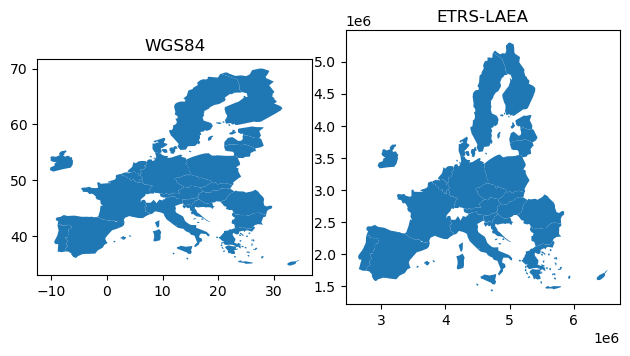

In [7]:
import matplotlib.pyplot

# Prepare sub plots that are next to each other
figure, (axis1, axis2) = matplotlib.pyplot.subplots(nrows=1, ncols=2)

# Plot the original (WGS84, EPSG:4326) data set
eu_countries.plot(ax=axis1)
axis1.set_title("WGS84")
axis1.set_aspect(1)

# Plot the reprojected (EPSG:3035) data set
eu_countries_EPSG3035.plot(ax=axis2)
axis2.set_title("ETRS-LAEA")
axis2.set_aspect(1)

matplotlib.pyplot.tight_layout()

Indeed, the maps look quite different, and the re-projected data set distorts
the European countries less, especially in the Northern part of the continent.

Let’s still save the reprojected data set in a file so we can use it later.
Note that, even though modern file formats save the CRS reliably, it is a good
idea to use a descriptive file name that includes the reference system
information.

In [ ]:
eu_countries_EPSG3035.to_file(
    DATA_DIRECTORY / "eu_countries" / "eu_countries_EPSG3035.gpkg"
)

---


## Handling different CRS formats

There are different ways to store and represent CRS information. The more
commonly used formats include [PROJ
strings](https://proj.org/usage/quickstart.html), EPSG codes, *Well-Known-Text*
(WKT) and JSON. You will likely encounter some or all of these when working
with spatial data obtained from different sources. Being able to convert CRS
information from one format to another is needed every now and then, hence, it
is useful to know a few tricks how to do this.

We’ve already briefly mentioned that geopandas uses the
[pyproj](https://pyproj4.github.io/pyproj/) library to handle reference
systems. We can use the same module to parse and convert CRS information in
different formats.


### Overview

Below we print different representations of the CRS of the data set of EU
countries we used before:

In [8]:
import pyproj

crs = pyproj.CRS(eu_countries.crs)

print(f"CRS as a proj4 string: {crs.to_proj4()}\n")

print(f"CRS in WKT format: {crs.to_wkt()}\n")

print(f"EPSG code of the CRS: {crs.to_epsg()}\n")

CRS as a proj4 string: +proj=longlat +datum=WGS84 +no_defs +type=crs

CRS in WKT format: GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],MEMBER["World Geodetic System 1984 (G2296)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]

EPSG code of the CRS: 4326



c:\Users\mbi\AppData\Local\miniconda3\envs\autogis\lib\site-packages\pyproj\crs\crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


> **Note**  
> Not every possible coordinate reference system has an EPSG code assigned. That’s why *pyproj*, by default, tries to find the best-matching EPSG definition. If it does not find any, `to_epsg()` returns `None`.




### Use pyproj to find detailed information about a CRS

A `pyproj.CRS` object can also be initialised manually, for instance, using an
EPSG code or a Proj4-string. It can then provide detailed information on the
parameters of the reference system, as well as suggested areas of use. We can,
for example, create a `CRS` object for the `EPSG:3035` map projection we used
above:

In [9]:
crs = pyproj.CRS("EPSG:4326")
crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Immediately, we see that a `pyproj.CRS` object contains rich information about
the reference system: a *name*, an *area of use* (including *bounds*), a
*datum* and an *ellipsoid*.

This information can also be extraced individually:

In [10]:
crs.name

'WGS 84'

In [11]:
crs.area_of_use.bounds

(-180.0, -90.0, 180.0, 90.0)

---


# Global map projections

Finally, it’s time to play around with some map projections. For this, you will
find a global data set of country polygons in the data directory. It was
downloaded from [naturalearthdata.com](https://naturalearthdata.com/), a
fantastic resource for cartographer-grade geodata.


> **Attention: Check your understanding**  
> Read in the data set from `DATA_DIRECTORY / "world_countries" / "ne_110m_admin_0_countries.zip"` and plot three maps with different map projections. You can use the hints and definitions from the following resources (and anywhere else):
> 
> - [geopandas.org/projections.html](http://geopandas.org/projections.html)
> - [pyproj4.github.io](https://pyproj4.github.io/pyproj/dev/api/crs.html)
> - [spatialreference.org](https://spatialreference.org/)
> 
> While plotting the maps and choosing map projections, think about the advantages and disadvantages of different map projections.


In [12]:
world_countries = geopandas.read_file(
    DATA_DIRECTORY / "world_countries" / "ne_110m_admin_0_countries.zip"
)

Text(0.5, 1.0, 'WGS 84')

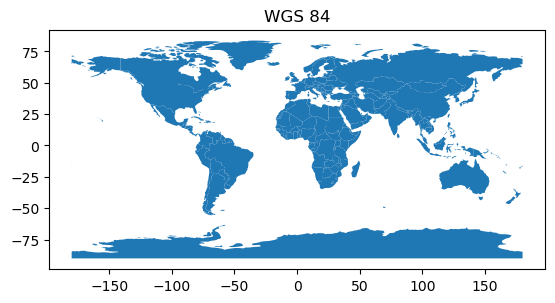

In [13]:
world_countries.plot()
matplotlib.pyplot.title(world_countries.crs.name)

(np.float64(-22041259.17706817),
 np.float64(22041259.177068174),
 np.float64(-255577115.13568556),
 np.float64(31488437.087057084))

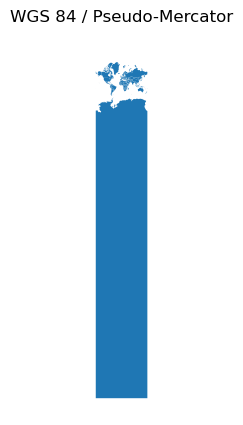

In [14]:
# web mercator
world_countries_EPSG3857 = world_countries.to_crs("EPSG:3857")

world_countries_EPSG3857.plot()
matplotlib.pyplot.title(world_countries_EPSG3857.crs.name)

# remove axis decorations
matplotlib.pyplot.axis("off")

(np.float64(-18321736.696081996),
 np.float64(18321736.696081996),
 np.float64(-9302420.503183275),
 np.float64(9217598.414473996))

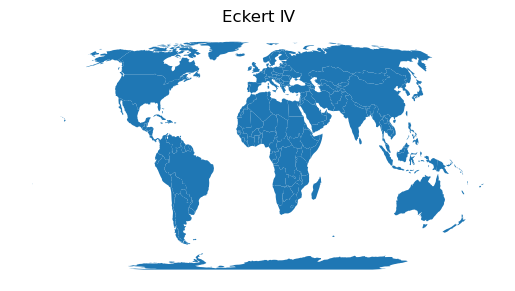

In [15]:
# Eckert-IV (https://spatialreference.org/ref/esri/54012/)
ECKERT_IV = "+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

world_countries_eckert_iv = world_countries.to_crs(ECKERT_IV)
world_countries_eckert_iv.plot()
matplotlib.pyplot.title("Eckert Ⅳ")
matplotlib.pyplot.axis("off")

(np.float64(-7006995.416935118),
 np.float64(7005877.340582642),
 np.float64(-6968264.187936907),
 np.float64(6378854.706416504))

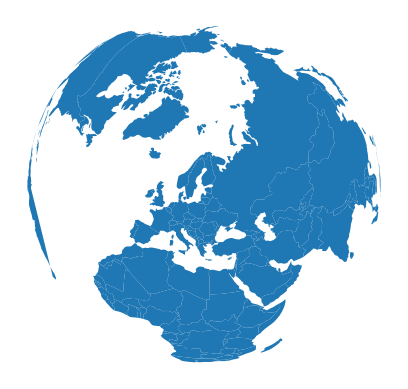

In [16]:
# An orthographic projection, centered in Finland!
# (http://www.statsmapsnpix.com/2019/09/globe-projections-and-insets-in-qgis.html)
world_countries_ortho = world_countries.to_crs(
    "+proj=ortho +lat_0=60.00 +lon_0=23.0000 +x_0=0 +y_0=0 "
    "+a=6370997 +b=6370997 +units=m +no_defs"
)
world_countries_ortho.plot()
matplotlib.pyplot.axis("off")